# Exponea internship assignment  
**Author: ** Jakub Bahyl  

The whole content is already pre-scripted for you.

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# function for class predicting based on model
def predict_class(model, x_test):
    y_pred = model.predict(x_test)
    y_prob = model.predict_proba(x_test)[:,1]
    
    return y_pred, y_prob

# correlation matrix plot
def plot_corr_matrix(data, labels):
    correlations = data.corr()

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(correlations, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(labels),1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(labels, rotation='vertical')
    ax.set_yticklabels(labels)
    plt.show()

# scale continuous data with gaussian distro
def scale_cont_data(data, num_cont):
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    data[:,:num_cont] = scaler.fit(data[:,:num_cont]).transform(data[:,:num_cont])
    
    return data

# predict and print report
def show_summary(model, x_test, y_test):
    from sklearn.metrics import classification_report
    y_pred, y_prob = predict_class(model, x_test)

    model.report = classification_report(y_test, y_pred, target_names=["no","yes"])
    print(model.report)

# plot confusion table and ROC curve
def plot_conf_ROC(model, x_test, y_test):
    from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
    import seaborn as sns
    
    # calculate class predictions and probabilities
    y_pred, y_prob = predict_class(model, x_test)
    
    # accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # confusion matrix
    conf = confusion_matrix(y_test, y_pred)

    # visualize conf table and ROC curve
    plt.figure(figsize=(14,7))

    plt.subplot(121)
    sns.heatmap(conf, annot=True, fmt=".0f", linewidths=.5, square = True)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Accuracy Score: {0:.2f}%'.format(100*accuracy)
    plt.title(all_sample_title, size = 15)

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    plt.subplot(122)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.title('ROC curve (AUC = {0:.2f}%)'.format(100*auc_score))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

## Loading data  
Feature names are extracted from `churn.names` file and data from `churn.all` file. After that, I'm seeking for any broken / missing data. Fortunately, every piece of data was fine.

In [95]:
# parsing feature names from churn.names
with open('src/churn.names', 'r') as f:
    labels = [row.split(":")[0] for row in f.readlines() if ":" in row]
    labels.append("class")

# parsing data
data = pd.read_csv('src/churn.all', names=labels)

# searching for invalid data
print(np.where(pd.isnull(data)))
print(np.where(data.applymap(lambda x: x in ['', ' ', None])))

# --> empty arrays = no invalid data

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


## Rough look  
Taking look on first five rows...

In [96]:
# show first 5 rows
data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,number customer service calls,class
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [4]:
data.dtypes

state                             object
account length                     int64
area code                          int64
phone number                      object
international plan                object
voice mail plan                   object
number vmail messages              int64
total day minutes                float64
total day calls                    int64
total day charge                 float64
total eve minutes                float64
total eve calls                    int64
total eve charge                 float64
total night minutes              float64
total night calls                  int64
total night charge               float64
total intl minutes               float64
total intl calls                   int64
total intl charge                float64
number customer service calls      int64
class                             object
dtype: object

Apparently, there are several problems with data:  
* **Unuseful data** - in purpose of predicitng churn, there is no reason to hold data like *state*. *area code* (fun fact: all present area codes are from California) and *phone numbers*. Such data would only make noise in predictions.
* **Strings instead of values** - "yes" or "True." should be rewritten into binary form (0 and 1)


## Reformatting and cleaning

In [97]:
# fixing formats of binary valued features
data['international plan'] = data['international plan'].map({' yes': 1, ' no': 0})
data['voice mail plan'] = data['voice mail plan'].map({' yes': 1, ' no': 0})
data['class'] = data['class'].map({' False.': 0, ' True.': 1})

# dropping unuseful features - states, area codes, phone numbers
data.drop(['state', 'area code', 'phone number'], 1, inplace=True)

# updating labels list
labels = list(data)

## Cleaning based on correlation matrix  
Some features could be extremely correlated one with other. For instance, clearly *total day minutes* and *total day charge* will be correlated, since charge is directly affected by the number of minutes spent.  

Such data are unuseful and therefore can be left behind.

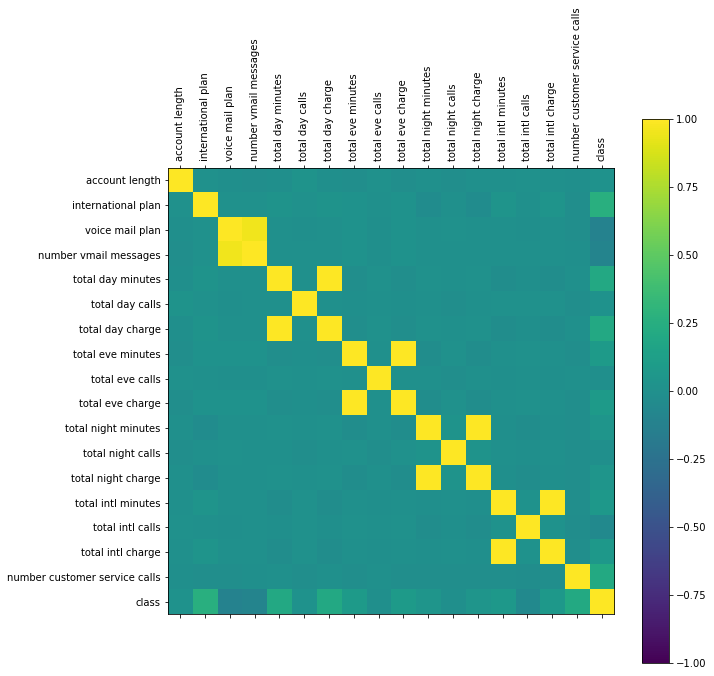

In [6]:
# correlation matrix visualisation
plot_corr_matrix(data, labels)

## Feature partners with high correlation:  

Pairs coloured yellow are feature partners with extremely high correlation.

Particularly:

"voice mail plan" ~= "number vmail messages"  
"total day minutes" ~= "total day charge"  
"total eve minutes" ~= "total eve charge"  
"total night minutes" ~= "total night charge"  
"total inti minutes" ~= "total inti charge"  

In [98]:
# dropping the second corr partners
data.drop(['number vmail messages',
           'total day charge',
           'total eve charge',
           'total night charge',
           'total intl charge'], 1, inplace=True)

# updating labels
labels = list(data)
labels_features = labels[:-1]

##  Preparing data for Logistic Regression

Generally, all categorical variables which are multi-leveled (taking discrete values "A", "B" and "C", etc.) should be rewritten into logical form ("containing A", "not containing B", ""not containing C", etc.).

In case of continuous variables, all of them should be normalised to symmetrical range based on their distribution.

Below, I'm visualising all pairs of feature plots in order to identify the categorical ones and predict their distribution.

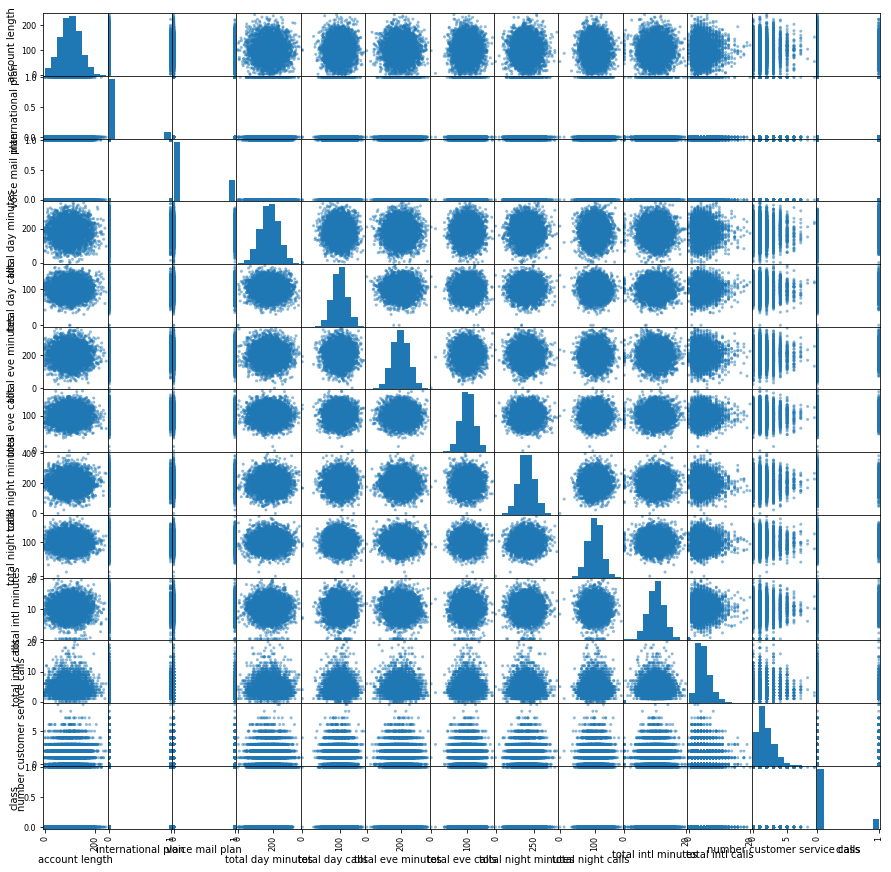

In [8]:
from pandas.plotting import scatter_matrix

# looking for categorical variables
scatter_matrix(data, figsize=(15,15))
plt.show()

Apparently, there are present 3 categorical features (*international plan*, *voice mail plan* and *churn*). All other features should be considered as continuous (could take any value). Although, feature *number customer service calls* seems like continuous, it isn't. There are only 10 different values present in data (from 0 to 9) and therefore can be considered as categorical.

# Logistic Regression  
Logistic Regression is type of ML algorithm, for which is more strategical to consider single-valued or discretely distributed data as categorical than continuous.   

Therefore I'm *dummyfying* the *number customer service calls* feature -> creating 9 more rows (*service calls_1, service calls)2,...* - not "0", this is deafault) with logical values.

## Dummifying feature "*number customer service calls*"

In [99]:
# picking categorical variables
categ_labels = ['international plan', 'voice mail plan', 'class', 'number customer service calls']

# data subset with categorical variables
data_categ = data.loc[:,categ_labels]

# data subset with continuous variables
data_cont = data.drop(categ_labels, 1)

# making "number customer service calls" variable dummified
dummy_customer = pd.get_dummies(data_categ['number customer service calls'], prefix='service calls')
data_categ.drop('number customer service calls', 1, inplace=True)
data_categ = data_categ.join(dummy_customer.loc[:,'service calls_1':]) 
# service calls_0 is left as default

# data prepared for logistic regression (and sorted cont-categ)
data_logit = data_cont.join(data_categ)

## Splitting and normalizing data  for logit

Almost all continuous variables in plot above were gaussian-like distributed. Therefore all of them should be normalised in a gaussian-like way (mean=0, devaition=1). Also, this normalisation should be done after splitting dataset into training and testing set (to ensure same scales for both parts).

In [103]:
from sklearn.model_selection import train_test_split

X = data_logit.drop("class", 1).values
Y = data_logit["class"]

# splitting 50:50 using random seeder
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=123)

# number of cont variables
num_cont = len(labels) - len(categ_labels)

# Training data scaling
X_train = scale_cont_data(X_train, num_cont)

# Testing data scaling
X_test = scale_cont_data(X_test, num_cont)

## Searching tuning parameters for Logit  

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# testing logit with various  values
C_range = [0.01,0.1,1,10,100,1000] # regularization
penalty_range = ['l1', 'l2'] # ridge and lasso method

param_grid = {'C': C_range,
              'penalty': penalty_range}

grid_search = GridSearchCV(LogisticRegression(fit_intercept = True, 
                                              class_weight="balanced"), 
                           param_grid=param_grid, 
                           scoring="f1")

grid_search.fit(X_train, Y_train)

# print the best parameters
print(grid_search.best_params_)

{'C': 100, 'penalty': 'l1'}


## Logit summary

['account length', 'total day minutes', 'total day calls', 'total eve minutes', 'total eve calls', 'total night minutes', 'total night calls', 'total intl minutes', 'total intl calls', 'international plan', 'voice mail plan', 'class', 'service calls_1', 'service calls_2', 'service calls_3', 'service calls_4', 'service calls_5', 'service calls_6', 'service calls_7', 'service calls_8', 'service calls_9']
Odds ratios: 
[[  1.27124485e+00   2.49424075e+00   9.72997587e-01   1.46164561e+00
    1.00325841e+00   1.39017180e+00   9.15868183e-01   1.38414415e+00
    7.92025174e-01   1.44248395e+01   3.70814664e-01   9.66942759e-01
    1.11785615e+00   8.08898800e-01   3.19108857e+01   5.47060110e+01
    8.89708768e+01   1.46624479e+01   1.00000000e+00   8.13242756e+02]]
             precision    recall  f1-score   support

         no       0.97      0.84      0.90      2144
        yes       0.47      0.82      0.59       356

avg / total       0.89      0.84      0.86      2500



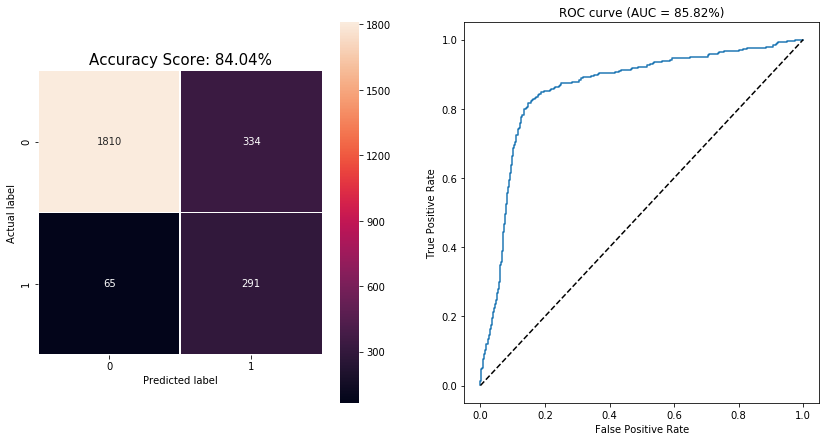

In [105]:
# Train the final model
logit = LogisticRegression(fit_intercept = True, 
                           class_weight="balanced",
                           penalty="l1",
                           C=100)

logit.fit(X_train, Y_train)

# print odds ratios

print(list(data_logit))
print("Odds ratios: ")
print(np.exp(logit.coef_))

show_summary(logit, X_test, Y_test)

plot_conf_ROC(logit, X_test, Y_test)

## Decision Tree model

This model is based on most effective decision for splitting data. Therefore there is no need for normalising nor dummifying data. Once again, I'm trying all reasonable parameters such as tree depth, number of features in one splitting,..

In [36]:
from sklearn.tree import DecisionTreeClassifier

# using old non-normalized data
X = data.drop("class", 1).values
Y = data["class"]

# splitting 50:50 using random seeder
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=123)

# testing DT with various parameters
minleaf_range = [1,2,3,5]
minsplit_range = [2,5,10,15,20]
maxdepth_range = [2,3,5,8,10]

param_grid = {'min_samples_leaf': minleaf_range,
              'min_samples_split': minsplit_range,
              'max_depth': maxdepth_range}

grid_search = GridSearchCV(DecisionTreeClassifier(criterion = "entropy", 
                                                  random_state = 100), 
                           param_grid=param_grid, scoring="f1")

grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)

{'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 15}


             precision    recall  f1-score   support

         no       0.94      0.99      0.97      2144
        yes       0.90      0.65      0.76       356

avg / total       0.94      0.94      0.94      2500



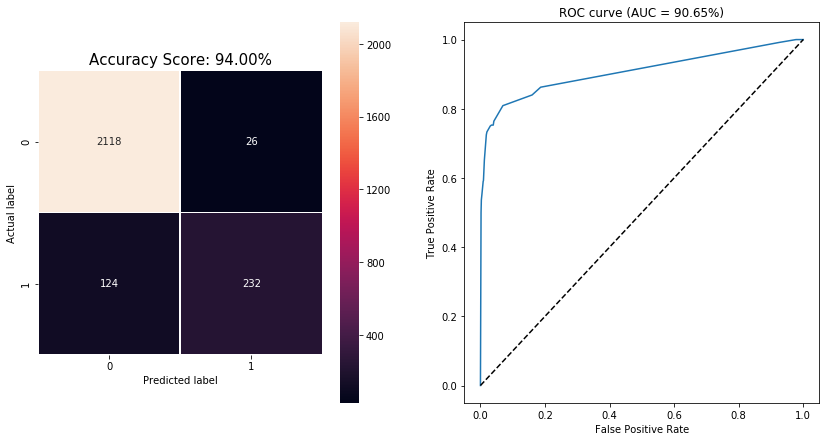

['account length', 'international plan', 'voice mail plan', 'total day minutes', 'total day calls', 'total eve minutes', 'total eve calls', 'total night minutes', 'total night calls', 'total intl minutes', 'total intl calls', 'number customer service calls', 'class']


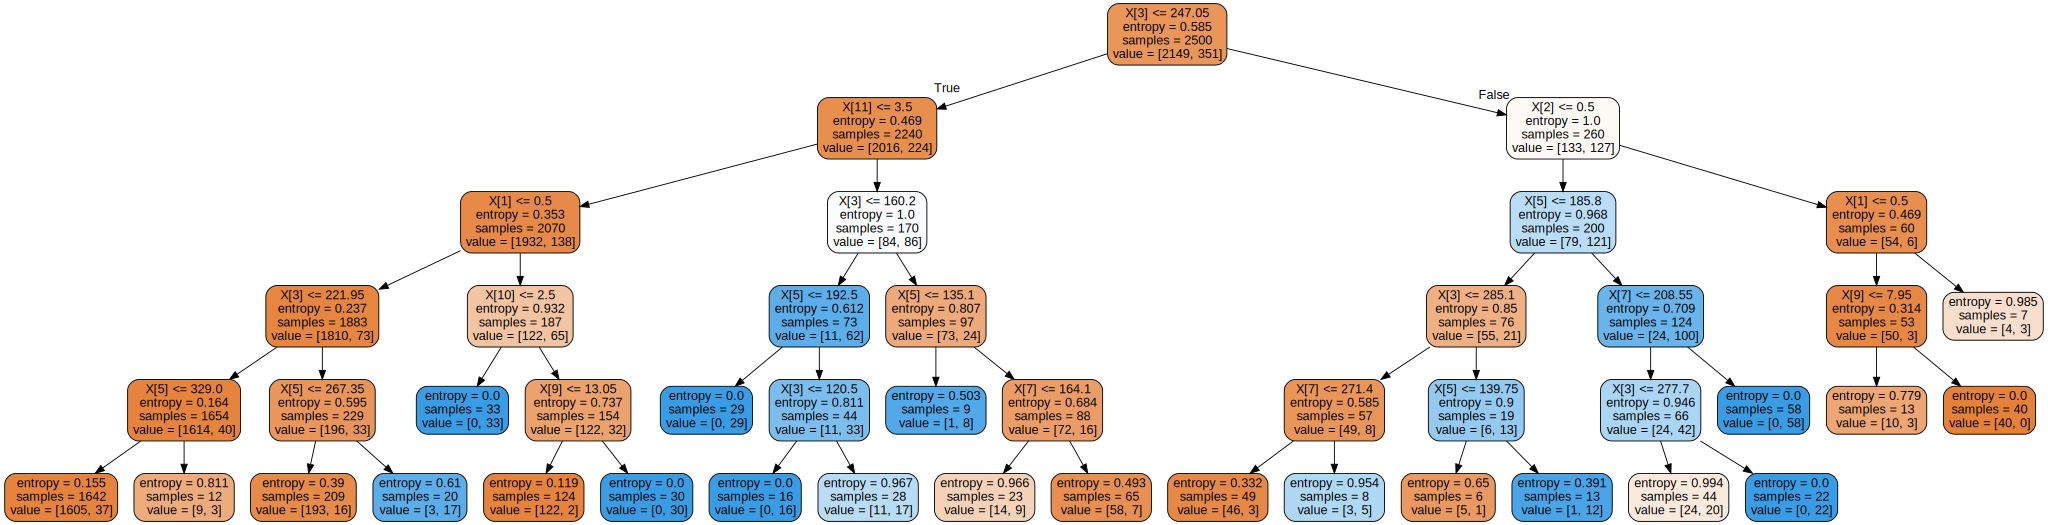

In [37]:
# Train the final model
tree = DecisionTreeClassifier(criterion = "entropy", 
                              random_state = 100, 
                              max_depth=5, 
                              min_samples_leaf=3,
                              min_samples_split=15)
tree.fit(X_train, Y_train)

show_summary(tree, X_test, Y_test)
plot_conf_ROC(tree, X_test, Y_test)

from sklearn.tree import export_graphviz
from graphviz import Source

# make dotted file and visualize tree
export_graphviz(tree, out_file="src/tree.dot", filled=True, rounded=True, max_depth=5)
with open("src/tree.dot") as f:
    dot_graph = f.read()

print(list(data))
Source(dot_graph)

After all, decision tree went quite better than Logistic regression (especially in accuracy).

## Random Forest

In [224]:
from sklearn.ensemble import RandomForestClassifier

# testing RF with various parameters
minleaf_range = [1,2,5]
minsplit_range = [2,5,8,10]
maxdepth_range = [5,10,12,15]
boot_range = [True, False]

param_grid = {'min_samples_leaf': minleaf_range,
              'min_samples_split': minsplit_range,
              'max_depth': maxdepth_range,
              'bootstrap': boot_range}

grid_search = GridSearchCV(RandomForestClassifier(criterion = "entropy", 
                                                  random_state = 100,
                                                  n_estimators=500), 
                           param_grid=param_grid, 
                           scoring="accuracy",
                           n_jobs = -1)

# print the best params
grid_search.fit(X_train, Y_train)
print(grid_search.best_params_)

{'bootstrap': False, 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 8}


             precision    recall  f1-score   support

         no       0.96      0.99      0.98      2144
        yes       0.96      0.72      0.83       356

avg / total       0.96      0.96      0.95      2500



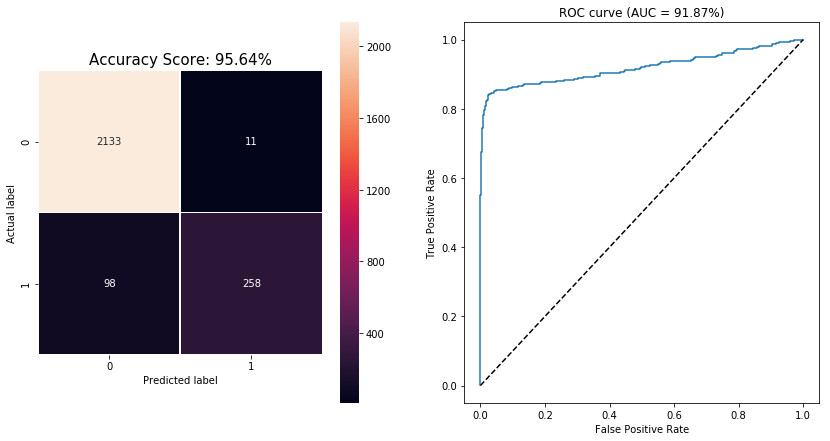

In [39]:
# Train the final model
forest = RandomForestClassifier(criterion = "entropy", 
                                random_state = 100,
                                n_estimators=2000,
                                max_depth=15, 
                                min_samples_leaf=1,
                                min_samples_split=10,
                                bootstrap=False,
                                n_jobs = -1)
forest.fit(X_train, Y_train)

show_summary(forest, X_test, Y_test)
plot_conf_ROC(forest, X_test, Y_test)

## Feature importance

<Container object of 12 artists>

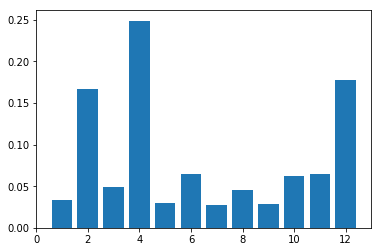

In [40]:
from sklearn.ensemble import ExtraTreesClassifier

# fit an Extra Trees model to the data
extra = ExtraTreesClassifier(criterion = "entropy", 
                             random_state = 100,
                             n_estimators=2000,
                             max_depth=12, 
                             min_samples_leaf=1,
                             min_samples_split=10,
                             bootstrap=False)
extra.fit(X_train, Y_train)

# display the relative importance of each attribute
plt.bar(np.arange(1,13), height=extra.feature_importances_)

In [91]:
# table with features and their importances
importance = pd.DataFrame(extra.feature_importances_, np.array(labels_features))
importance.columns = ['importance']
importance.sort_values(by='importance', ascending=False)

,importance
total day minutes,0.248864
number customer service calls,0.177682
international plan,0.167354
total intl calls,0.064842
total eve minutes,0.064556
total intl minutes,0.062749
voice mail plan,0.049014
total night minutes,0.045573
account length,0.033570
total day calls,0.029383
